In [ ]:
#@title Import Dependencies

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix,silhouette_score
import sklearn.metrics.cluster as smc
from sklearn.metrics import cohen_kappa_score

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,LabelEncoder, MinMaxScaler, Normalizer
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.decomposition import PCA
from sklearn.svm import SVC  #SVM classifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import itertools
import numpy as np
import seaborn as sns

In [ ]:
#@title Function Declarations

# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.YlOrBr)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)

    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


def make_meshgrid(x, y, h=0.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

def draw_contour(x,y,clf, class_labels = ["Negative", "Positive"]):
    """
    Draws a contour line for the predictor

    Assumption that x has only two features. This functions only plots the first two columns of x.

    """

    X0, X1 = x[:, 0], x[:, 1]
    xx0, xx1 = make_meshgrid(X0,X1)

    plt.figure(figsize = (10,6))
    plot_contours(clf, xx0, xx1, cmap="PiYG", alpha=0.8)
    scatter=plt.scatter(X0, X1, c=y, cmap="PiYG", s=30, edgecolors="k")
    plt.legend(handles=scatter.legend_elements()[0], labels=class_labels)

    plt.xlim(xx0.min(), xx0.max())
    plt.ylim(xx1.min(), xx1.max())

In [ ]:
#@title Data Ingest and Encoding

# Read the CSV file
df = pd.read_csv('output_new.csv')

#Perform data analysis
#Example: Clustering based on artist familiarity and artist hotttnesss
data = df[['artist_familiarity', 'artist_hotttnesss', 'duration', 'song_key', 'loudness', 'tempo','song_hotttnesss', 'end_of_fade_in', 'mode', 'time_signature']]

data = data[data['song_hotttnesss'].notna()]
data = data[data['song_hotttnesss'] != 0]
data = data.fillna(data.mean())

#format the (abc, ) to abc
data['tempo'] = data['tempo'].str.replace(r"[\(\),]", "", regex=True).str.strip().astype(float)
data['song_key'] = data['song_key'].str.replace(r"[\(\),]", "", regex=True).str.strip().astype(float)
data['loudness'] = data['loudness'].str.replace(r"[\(\),]", "", regex=True).str.strip().astype(float)
data['end_of_fade_in'] = data['end_of_fade_in'].str.replace(r"[\(\),]", "", regex=True).str.strip().astype(float)
data['mode'] = data['mode'].str.replace(r"[\(\),]", "", regex=True).str.strip().astype(float) #Measures whether major or minor key
data['time_signature'] = data['time_signature'].str.replace(r"[\(\),]", "", regex=True).str.strip().astype(float)

df = df[df['song_hotttnesss'].notna()]
dfDropped = df[df['song_hotttnesss'] != 0]

#Change song_hotttnesss to binary 0/1 for classification
data['song_hotttnesss'] = np.where(data['song_hotttnesss'] > 0.5, 1, 0)

<ipython-input-3-374c8cd6ebf0>:12: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = data.fillna(data.mean())


###Exploratory Data Analysis

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4214 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   artist_familiarity  4214 non-null   float64
 1   artist_hotttnesss   4214 non-null   float64
 2   duration            4214 non-null   float64
 3   song_key            4214 non-null   float64
 4   loudness            4214 non-null   float64
 5   tempo               4214 non-null   float64
 6   song_hotttnesss     4214 non-null   int64  
 7   end_of_fade_in      4214 non-null   float64
 8   mode                4214 non-null   float64
 9   time_signature      4214 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 362.1 KB


In [ ]:
#Examine if there are more features/rows needed to impute or drop
data.isnull().sum()

artist_familiarity    0
artist_hotttnesss     0
duration              0
song_key              0
loudness              0
tempo                 0
song_hotttnesss       0
end_of_fade_in        0
mode                  0
time_signature        0
dtype: int64

array([[<Axes: title={'center': 'artist_familiarity'}>,
        <Axes: title={'center': 'artist_hotttnesss'}>,
        <Axes: title={'center': 'duration'}>],
       [<Axes: title={'center': 'song_key'}>,
        <Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'tempo'}>],
       [<Axes: title={'center': 'song_hotttnesss'}>,
        <Axes: title={'center': 'end_of_fade_in'}>,
        <Axes: title={'center': 'mode'}>],
       [<Axes: title={'center': 'time_signature'}>, <Axes: >, <Axes: >]],
      dtype=object)

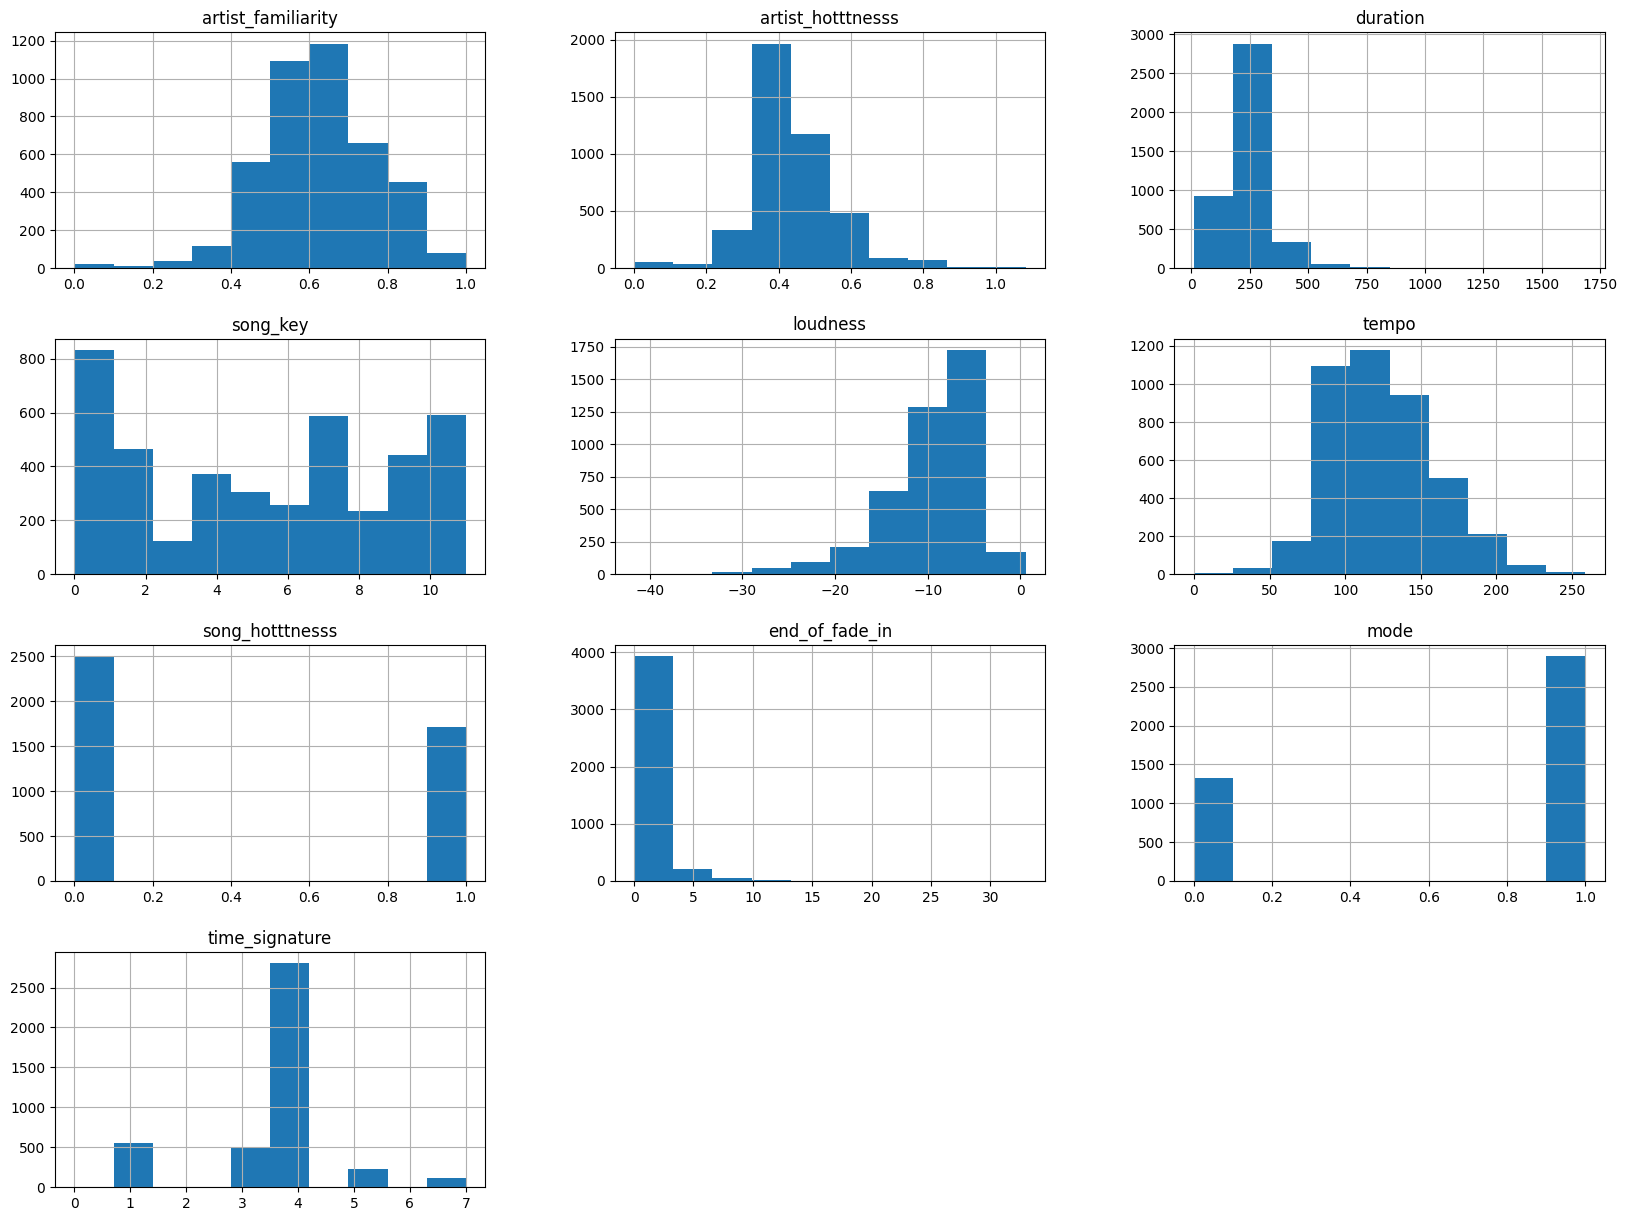

In [ ]:
#Plot distributions of each parameter
data.hist(figsize= (20,15))

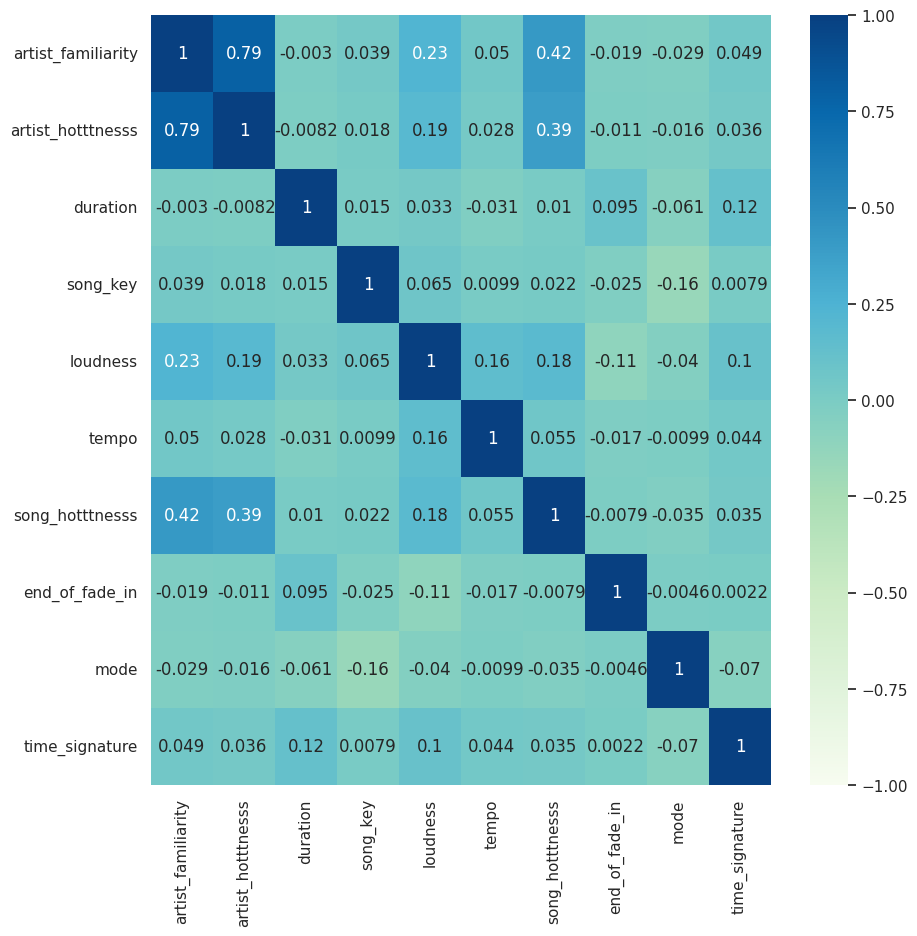

In [ ]:
#Correlation Matrix Heatmap
corrMatrix = data.corr()
sns.set()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, vmin = -1, vmax = 1, annot = True, cmap = 'GnBu')
plt.show()

In [ ]:
correlations = data.corr()
correlations["song_hotttnesss"].sort_values(ascending=False)

song_hotttnesss       1.000000
artist_familiarity    0.415185
artist_hotttnesss     0.388741
loudness              0.181699
tempo                 0.054808
time_signature        0.034739
song_key              0.021710
duration              0.010406
end_of_fade_in       -0.007857
mode                 -0.034809
Name: song_hotttnesss, dtype: float64

Text(0, 0.5, 'song_hotttnesss')

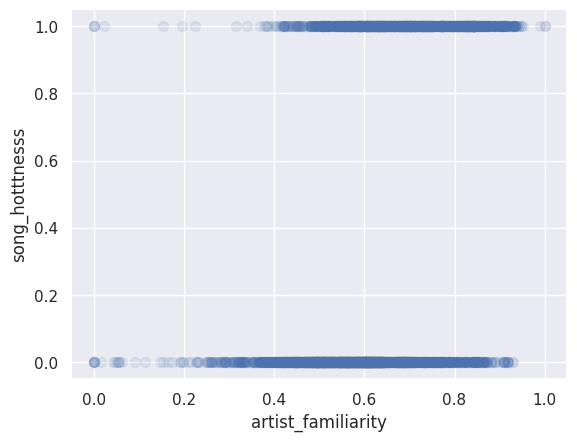

In [ ]:
plt.scatter(data['artist_familiarity'], data['song_hotttnesss'], s = 50, alpha = 0.10)
plt.xlabel('artist_familiarity')
plt.ylabel('song_hotttnesss')

Text(0, 0.5, 'song_hotttnesss')

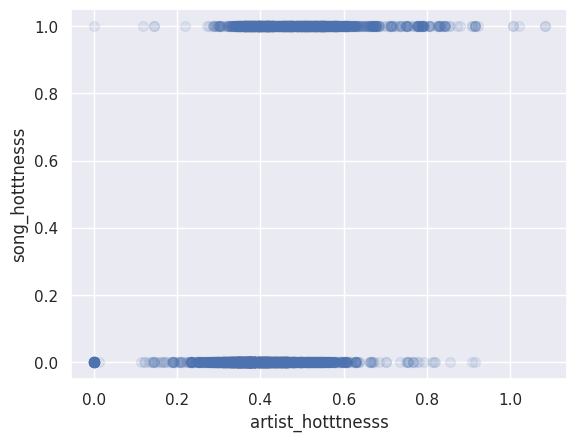

In [ ]:
plt.scatter(data['artist_hotttnesss'], data['song_hotttnesss'], s = 50, alpha = 0.10)
plt.xlabel('artist_hotttnesss')
plt.ylabel('song_hotttnesss')

Text(0, 0.5, 'artist_hotttnesss')

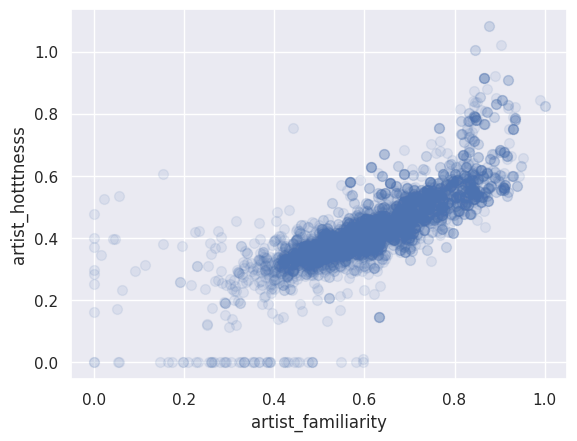

In [ ]:
plt.scatter(data['artist_familiarity'], data['artist_hotttnesss'], s = 50, alpha = 0.10)
plt.xlabel('artist_familiarity')
plt.ylabel('artist_hotttnesss')

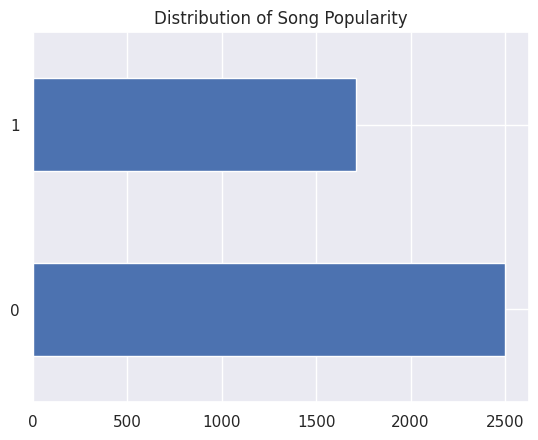

In [ ]:
data['song_hotttnesss'].value_counts().plot(kind = 'barh')
plt.title('Distribution of Song Popularity')
plt.show()

###Train-Test-Split and Pipeline

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

y = data["song_hotttnesss"]
x = data.drop(["song_hotttnesss"], axis = 1)

#Defining numerical and categorical features
catCols = ['time_signature']
numericCols = ['artist_familiarity', 'artist_hotttnesss', 'duration', 'song_key', 'loudness', 'tempo', 'end_of_fade_in', 'mode']

#Standard Scaling numerical features, one hot encoding categorical features
numericPipeline = Pipeline([('stdScaler', StandardScaler())])
catPipeline = Pipeline([('OneHotEncoder', OneHotEncoder())])

#Wrap pipeline together
completePipeline = ColumnTransformer([
    ('numeric', numericPipeline, numericCols),
    ('categorical', catPipeline, catCols)
])

#Fit transform data
finalData = completePipeline.fit_transform(x)

In [ ]:
#Train-Test-Split
xTrain, xTest, yTrain, yTest = train_test_split(finalData, y , test_size = 0.2, stratify = y, random_state = 0)

In [ ]:
# Print out for sanity check
print(len(y))
print(len(xTrain))
print(len(xTest))
print(len(yTrain))
print(len(yTest))

4214
3371
843
3371
843


###k Nearest Neighbors

In [ ]:
param_grid = {'n_neighbors': [3, 5, 10, 15, 20, 25],
              'metric': ['manhattan', 'euclidean']}

knn = KNeighborsClassifier()
gridSearch = GridSearchCV(knn, param_grid, cv = 5)
gridSearch.fit(xTrain, yTrain)

print(f"Best parameters: {gridSearch.best_params_}")
print(f"Best score: {gridSearch.best_score_}")

Best parameters: {'metric': 'manhattan', 'n_neighbors': 25}
Best score: 0.696531926585339


In [ ]:
#Evaluate on Test Data
knn = KNeighborsClassifier(n_neighbors = 25, metric = 'manhattan')
knn.fit(xTrain, yTrain)

print("Accuracy:", knn.score(xTest, yTest))
predictions = knn.predict(xTest)
print("Cohen's kappa:", cohen_kappa_score(yTest, predictions))

Accuracy: 0.7034400948991696
Cohen's kappa: 0.35855683658189164


###Logistic Regression

In [ ]:
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'None'],
              'solver': ['lbfgs', 'liblinear', 'newton-cholesky', 'sag','saga']}

logReg = LogisticRegression()
gridSearch = GridSearchCV(logReg, param_grid, cv = 5)
gridSearch.fit(xTrain, yTrain)

print(f"Best parameters: {gridSearch.best_params_}")
print(f"Best score: {gridSearch.best_score_}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best parameters: {'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.7036500714364216


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
65 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

In [ ]:
#Evaluate on Test Data
logReg = LogisticRegression(penalty = 'l1', solver = 'liblinear')
logReg.fit(xTrain, yTrain)

print("Accuracy:", logReg.score(xTest, yTest))
predictions = logReg.predict(xTest)
print("Cohen's kappa:", cohen_kappa_score(yTest, predictions))

Accuracy: 0.7129300118623962
Cohen's kappa: 0.3820359499100343


### Decision Trees

In [ ]:
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_features': ['sqrt', 'log2', 'None']}

DecisionTree = DecisionTreeClassifier()
gridSearch = GridSearchCV(DecisionTree, param_grid, cv = 5)
gridSearch.fit(xTrain, yTrain)

print(f"Best parameters: {gridSearch.best_params_}")
print(f"Best score: {gridSearch.best_score_}")

Best parameters: {'criterion': 'entropy', 'max_features': 'log2'}
Best score: 0.6389818661391361


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validat

In [ ]:
#Evaluate on Test Data
DecisionTree = DecisionTreeClassifier(criterion = 'gini', max_features = 'log2')
DecisionTree.fit(xTrain, yTrain)

print("Accuracy:", DecisionTree.score(xTest, yTest))
predictions = DecisionTree.predict(xTest)
print("Cohen's kappa:", cohen_kappa_score(yTest, predictions))

Accuracy: 0.6393831553973903
Cohen's kappa: 0.25353466505880917


###Support Vector Classifier

In [ ]:
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

svc = SVC()
gridSearch = GridSearchCV(svc, param_grid, cv = 5)
gridSearch.fit(xTrain, yTrain)

print(f"Best parameters: {gridSearch.best_params_}")
print(f"Best score: {gridSearch.best_score_}")

Best parameters: {'kernel': 'linear'}
Best score: 0.7039463677327179


In [ ]:
svc = SVC(kernel = 'linear')
svc.fit(xTrain, yTrain)

print('Accuracy:', svc.score(xTest, yTest))
predictions = svc.predict(xTest)
print("Cohen's kappa:", cohen_kappa_score(yTest, predictions))

Accuracy: 0.7117437722419929
Cohen's kappa: 0.37800334607595165


###Random Forest

In [ ]:
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_features': ['sqrt', 'log2', 'None']}

randForest = RandomForestClassifier()
gridSearch = GridSearchCV(randForest, param_grid, cv = 5)
gridSearch.fit(xTrain, yTrain)

print(f"Best parameters: {gridSearch.best_params_}")
print(f"Best score: {gridSearch.best_score_}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils

Best parameters: {'criterion': 'log_loss', 'max_features': 'sqrt'}
Best score: 0.7075089570282449


In [ ]:
randForest = RandomForestClassifier(criterion = 'gini', max_features = 'sqrt', random_state = 0)
randForest.fit(xTrain, yTrain)

print('Accuracy:', randForest.score(xTest, yTest))
predictions = randForest.predict(xTest)
print("Cohen's kappa:", cohen_kappa_score(yTest, predictions))

Accuracy: 0.7058125741399762
Cohen's kappa: 0.3744494446572194


###Figure Generation

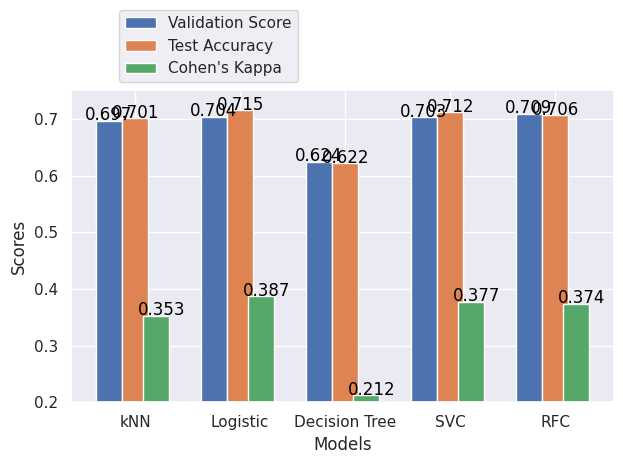

In [ ]:
validation = [0.697, 0.704, 0.624, 0.703, 0.709]
accuracy = [0.701, 0.715, 0.622, 0.712, 0.706]
cKappa = [0.353, 0.387, 0.212, 0.377, 0.374]

x = np.arange(5)
width = 0.25

#plt.figure(figsize = (10, 10))

plt.bar(x - 0.25, validation, width)
plt.bar(x, accuracy, width)
plt.bar(x + 0.20, cKappa, width)
plt.xticks(x, ['kNN', 'Logistic', 'Decision Tree', 'SVC', 'RFC'])
plt.xlabel("Models")
plt.ylabel("Scores")
plt.legend(['Validation Score', 'Test Accuracy', "Cohen's Kappa"], bbox_to_anchor=(0.075, 1))
plt.ylim(0.2, None)  # Set the lower limit to 0.8
plt.tight_layout()

# Annotate the bar plot with the actual values
for i, v in enumerate(validation):
    plt.text(i - 0.25, v + 0.001, str(v), color='black', ha='center')
for i, v in enumerate(accuracy):
    plt.text(i, v + 0.001, str(v), color='black', ha='center')
for i, v in enumerate(cKappa):
    plt.text(i + 0.25, v + 0.001, str(v), color='black', ha='center')

plt.show()

###Logistic Regression Redo with 2 parameters only

In [ ]:
#Read the CSV file
df = pd.read_csv('output_new.csv')

#Perform data analysis
#Example: Clustering based on artist familiarity and artist hotttnesss
data = df[['artist_familiarity', 'artist_hotttnesss', 'duration', 'song_key', 'loudness', 'tempo','song_hotttnesss']]

data = data.fillna(data.mean())

#format the (abc, ) to abc
data['tempo'] = data['tempo'].str.replace(r"[\(\),]", "", regex=True).str.strip().astype(float)
data['song_key'] = data['song_key'].str.replace(r"[\(\),]", "", regex=True).str.strip().astype(float)
data['loudness'] = data['loudness'].str.replace(r"[\(\),]", "", regex=True).str.strip().astype(float)

#Change song_hotttnesss to binary 0/1 for classification
data['song_hotttnesss'] = np.where(data['song_hotttnesss'] > 0.5, 1, 0)

<ipython-input-31-326197ca8a29>:8: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = data.fillna(data.mean())


In [ ]:
y = data['song_hotttnesss']
x = data.drop(['song_hotttnesss'], axis = 1)

train_raw, test_raw, target, target_test = train_test_split(x,y, test_size = 0.2, stratify = y, random_state = 0)

Accuracy:    0.829000
Cohen's kappa: 0.04147176125359808
Accuracy:    0.818500
Cohen's kappa: 0.16040633557841755
Accuracy:    0.818500
Cohen's kappa: 0.16295028893203534


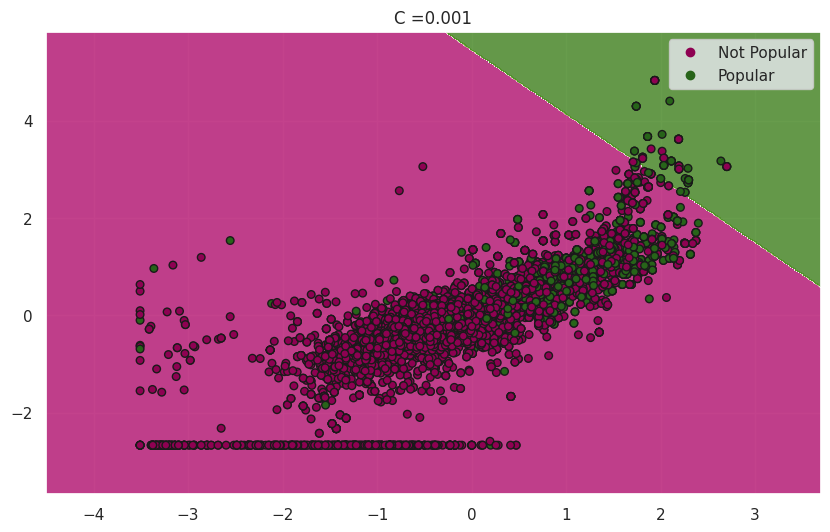

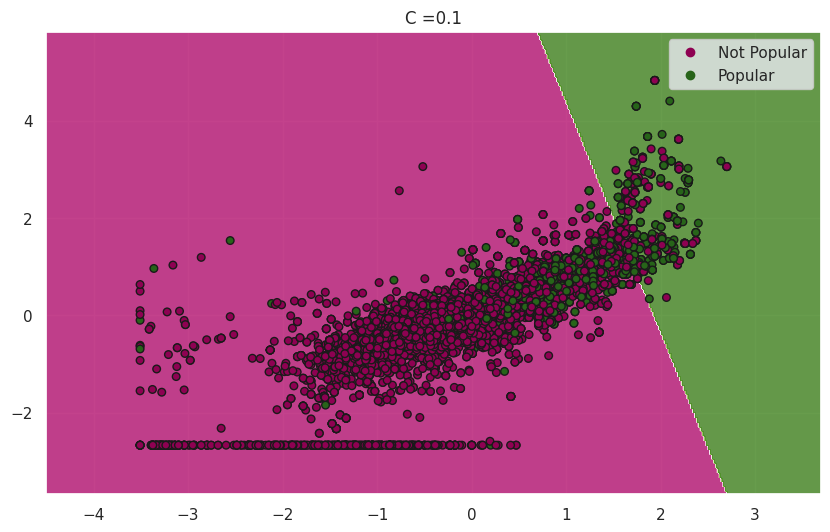

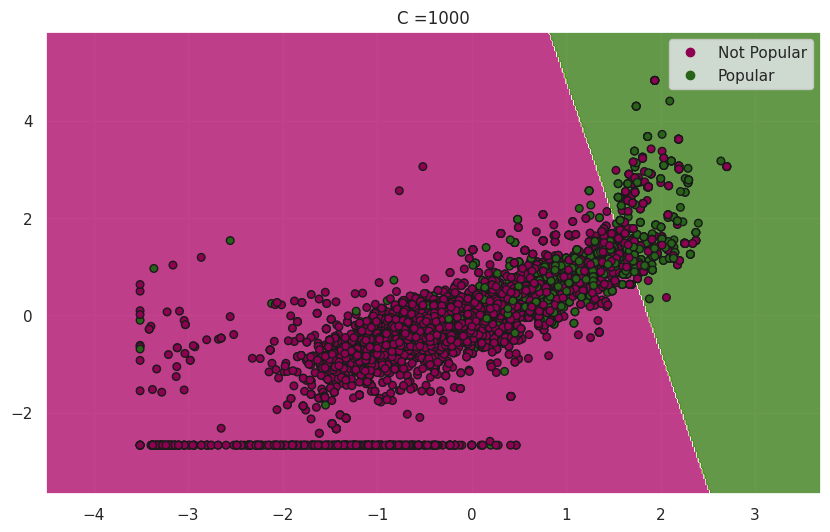

In [ ]:
train_2 = StandardScaler().fit_transform(train_raw[['artist_familiarity','artist_hotttnesss']])
test_2 = StandardScaler().fit_transform(test_raw[['artist_familiarity','artist_hotttnesss']])

#Defining the Cs we want to test
Cs  = [0.001,0.1,1000]
for C in Cs:
    log_reg = LogisticRegression(penalty = "l2",max_iter = 1000, solver = "lbfgs", C=C) #will change parameters during CV
    log_reg.fit(train_2, target)
    testing_result = log_reg.predict(test_2)
    predicted = log_reg.predict(test_2)

    #Output metrics
    print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
    print("Cohen's kappa:", cohen_kappa_score(target_test, predicted))

    #Plot decision boundary
    draw_contour(train_2,target,log_reg, class_labels = ['Not Popular', 'Popular'])
    plt.title(f"C ={C}")